In [3]:
from FDD import FDD
from FDD.SURE import SURE
import numpy as np
import pandas as pd
import torch 
from matplotlib import pyplot as plt
import matplotlib as mpl
import ray
#import boto3
import os
import pickle

def f(x, jumps):
    temp = x**2 + np.sin(10 * x)  # change 10 to any other value to adjust the frequency of oscillation
    for (xj, jj) in jumps:
        if x > xj:
            temp += jj
    return temp

# Redefine the function to generate data with larger jumps, with last one going down
def generate1D(jumps=[(0.2013934, 0.9), (0.4023231, 1), (0.590349, 1.5), (0.7893434, -2)], sigma=0.1, N=500):
    data = np.random.rand(N)  # draw N 1D points from a uniform

    # now sample the function values on the data points
    grid_f = np.zeros(data.shape)
    for i in range(data.shape[0]):
        grid_f[i] = f(data[i], jumps)

    # Normalize function values to [0, 1]
    grid_f = (grid_f - np.min(grid_f)) / np.max(grid_f)  # - np.min(grid_f))

    # now add noise
    grid_sample = grid_f + np.random.normal(loc=0, scale=sigma, size=data.shape)  # add random Gaussian noise
    
    # now cast this data into a standard data format
    X = data.copy()
    Y = grid_sample.copy()
    u = grid_f.copy()

    return (X, Y, u)

In [2]:
#----------------
# parameters
#----------------
sigma=0.05
S = 32
N = 2000
lmbda = 100
nu = 0.002
main_dir = "/Users/davidvandijcke/Dropbox (University of Michigan)/rdd"
figs_dir = os.path.join(main_dir, 'results', 'figs')

#------

fto = os.path.join(main_dir, 'data', 'out', "1D_SURE.pkl")
with open(fto, "rb") as f:
    res = pickle.load(f)

best = res.get_best_result(metric = "score", mode = "min")

config = best.metrics['config']
lmbda, nu = config['lmbda'], config['nu']



In [4]:
nu

0.0025094806348618438

In [9]:
np.random.seed(409)
# Generate data with reduced noise
X, Y, U = generate1D(sigma=0.05, N=N)



resolution = 1/int(Y.size*0.1)
model = FDD(Y, X, level = S, lmbda = lmbda, nu = nu, iter = 10000, tol = 5e-5, resolution=resolution,
    pick_nu = "MS", scaled = True, scripted = False)

u, jumps, J_grid, nrj, eps, it = model.run()

/Users/davidvandijcke/miniconda3/envs/fdd/lib/python3.9/site-packages/FDD/primaldual_multi_scaled_tune.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tauu = torch.tensor(  1.0 / torch.sqrt(denom) * res, device=dev)  # torch.tensor(  1.0 / 6.0 * res, device=dev) # *res
/Users/davidvandijcke/miniconda3/envs/fdd/lib/python3.9/site-packages/FDD/primaldual_multi_scaled_tune.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigmap = torch.tensor( 1.0 / torch.sqrt(denom)  * res, device=dev) # torch.tensor( (1.0 / (3.0 + l))  * res, device=dev) # *res


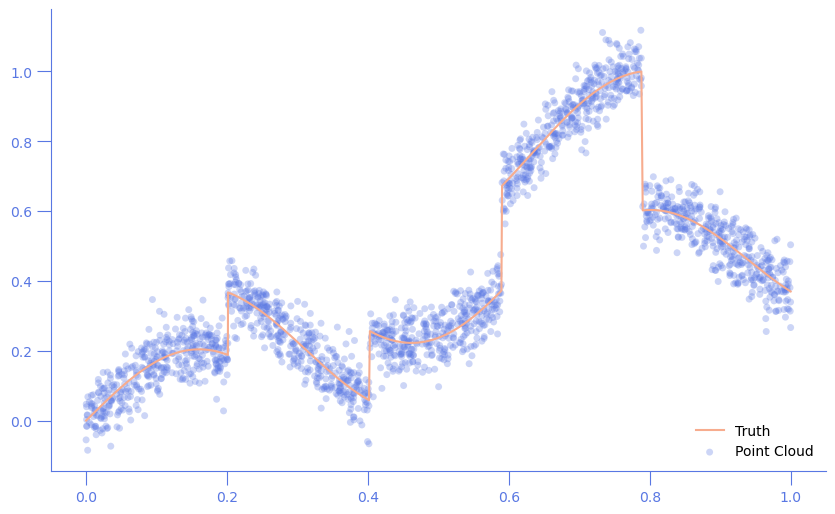

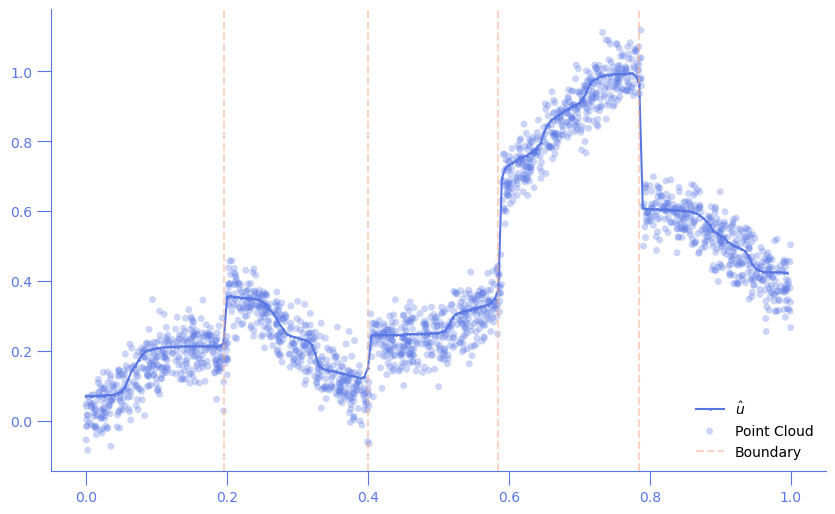

In [10]:
# plot figures
cmap = mpl.colormaps.get_cmap('coolwarm')
c1 = cmap(0.1)
c2 = cmap(0.7)

def prettify(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color(c1)
    ax.spines['bottom'].set_color(c1)
    ax.tick_params(axis='both', which='both', colors=c1, size=10)
    ax.yaxis.label.set_color(c1)
    ax.xaxis.label.set_color(c1)
    leg = plt.legend(loc="lower right")
    leg.get_frame().set_alpha(0)

# cb = "#d7e3ff"
# cr = "#f7ccc1"

# Sort data for plotting
sort_inds = np.argsort(X)
X_sorted = X[sort_inds]
Y_sorted = Y[sort_inds]
U_sorted = U[sort_inds]

# Plot truth
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(X_sorted, U_sorted, label='Truth', color=c2)
ax.scatter(X_sorted, Y_sorted, s=25, label='Point Cloud', color=c1,alpha=0.3, edgecolors='none')
prettify(ax)
plt.savefig(os.path.join(figs_dir, "simulation_1d_truth.pdf"), bbox_inches='tight')

# plot estimates 
fig, ax = plt.subplots(figsize=(10,6))
#plt.scatter(model.grid_x, u, s=1)
plt.plot(model.grid_x, u, '-o', markersize=1, c=c1, label = r"$\hat{u}$")
ax.scatter(X_sorted, Y_sorted, s=25, label='Point Cloud', color=c1,alpha=0.3, edgecolors='none')


jumplocs = (np.where(J_grid==1)[0] / J_grid.size).tolist()
for xc in jumplocs:
    if xc == jumplocs[0]:
        plt.axvline(x=xc, color=c2, linestyle='--', alpha=0.5, label="Boundary")
    else:
        plt.axvline(x=xc, color=c2, linestyle='--', alpha=0.5)

    
prettify(ax)
fn = os.path.join(figs_dir, "simulation_1d_estimate.pdf")
plt.savefig(fn, bbox_inches='tight')


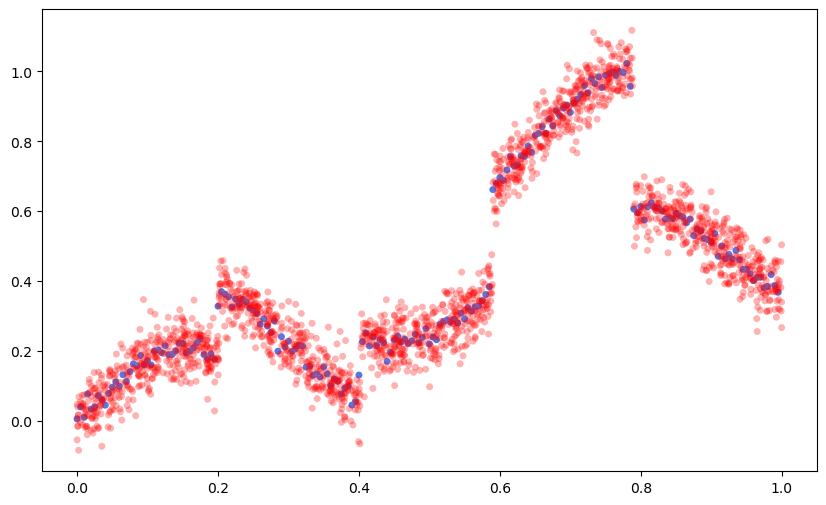

In [7]:
cmap = mpl.colormaps.get_cmap('coolwarm')
c1 = cmap(0.1)
c2 = cmap(0.7)

# Sort data for plotting
sort_inds = np.argsort(X)
X_sorted = X[sort_inds]
Y_sorted = Y[sort_inds]
U_sorted = U[sort_inds]

fig, ax = plt.subplots(figsize=(10,6))
#  * np.max(model.Y_raw) + np.min(model.Y_raw)
#plt.scatter(model.grid_x, u, s=1)
#plt.plot(model.grid_x, u, '-o', markersize=1, c=c1)
ax.scatter(model.grid_x, model.grid_y * np.max(model.Y_raw) + np.min(model.Y_raw), s=25, label='Point Cloud', color=c1, edgecolors='none')
ax.scatter(X_sorted, Y_sorted, s=25, label='Point Cloud', color="red",alpha=0.3, edgecolors='none')


In [6]:
import inspect
lines = inspect.getsource(FDD.__init__)
print(lines)

    def __init__(self, Y : np.array, X : np.array, pick_nu : str="kmeans", level : int=16, 
                 lmbda : float=1, nu : float=0.01, iter : int=1000, tol : float=5e-5, rectangle : bool=False, 
                 qtile : float=0.05, image : bool=False, grid : bool=False, resolution : float=None,
                 scaled=False, scripted=True, average=False) -> None:

        self.device = setDevice()
        torch.set_grad_enabled(False)
        
        self.Y_raw = Y.copy() # retain original data
        self.X_raw = X.copy()
        self.Y = Y.copy() # arrays I'll pass to PyTorch
        self.X = X.copy()
        
        self.image = image
        self.grid = grid
        self.level = level
        self.lmbda = lmbda
        self.iter = iter
        self.tol = tol
        self.rectangle = rectangle
        self.qtile = qtile
        self.resolution = resolution
        
        # for acceleration
        self.gamma = 1
        self.theta_u = 1 # placeholder
        self.theta_

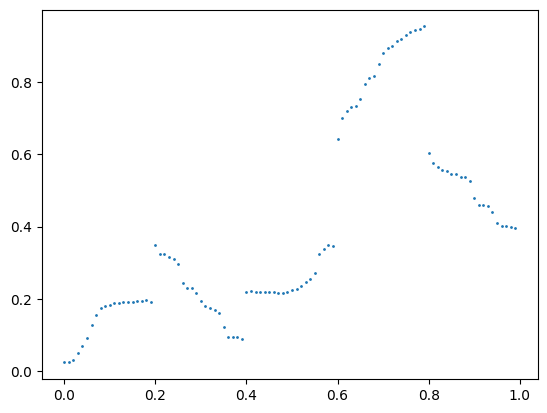

In [6]:
plt.scatter(model.grid_x, u, s=1)


In [10]:
 np.min(model.Y_raw)

-0.06612661481378704

In [11]:
from types import MethodType
        
def __init__(self, Y : np.array, X : np.array, pick_nu : str="kmeans", level : int=16, 
             lmbda : float=1, nu : float=0.01, iter : int=1000, tol : float=5e-5, rectangle : bool=False, 
             qtile : float=0.05, image : bool=False, grid : bool=False, resolution : float=None,
             scaled=False, scripted=True, average=False) -> None:

    self.device = setDevice()
    torch.set_grad_enabled(False)

    self.Y_raw = Y.copy() # retain original data
    self.X_raw = X.copy()
    self.Y = Y.copy() # arrays I'll pass to PyTorch
    self.X = X.copy()

    self.image = image
    self.grid = grid
    self.level = level
    self.lmbda = lmbda
    self.iter = iter
    self.tol = tol
    self.rectangle = rectangle
    self.qtile = qtile
    self.resolution = resolution

    # for acceleration
    self.gamma = 1
    self.theta_u = 1 # placeholder
    self.theta_mu = 1

    self.scripted = scripted
    self.scaled = scaled

    self.average = average


    if self.image: # if image, we don't scale -- assume between 0 and 1
        self.castImageToGrid()

    else:
        #self.normalizeData() # scale data to unit hypercube
        self.castDataToGrid()
        self.grid_y = (self.grid_y - np.min(self.Y_raw)) / np.max(self.Y_raw)

    # if pick_nu == "auto":
    #     u_diff = self.forward_differences(self.grid_y, D = len(self.grid_y.shape))
    #     u_diff = u_diff / self.resolution # scale FD by side length
    #     u_norm = np.linalg.norm(u_diff, axis = 0, ord = 2) # 2-norm
    #     self.nu = self.pickKMeans(u_norm)
    # else:
    self.nu = nu
    self.pick_nu = pick_nu

    if self.scripted:
        # scale gradients?
        if self.scaled:
            script = "scripted_primal_dual_scaled"
        else:
            script = "scripted_primal_dual"

        self.model = load_model(script + ".pt", device=self.device) #torch.jit.load(script + ".pt", map_location = self.device)
    else:
        self.model = PrimalDual()

    self.model = self.model.to(self.device)
    
model.__init__ = MethodType(__init__, model)